# Training UNet for drop segmentation

In [65]:
import torch
from checkpoints import *
from measures import *

In [201]:
config = {
    "lr": 0.0001,
    "batch_size": 4,
    "epochs": 10,
    "threshold": 0.3,
    "init_from_checkpoint": False,
    "image_dir": '../../data/stereo/train/image',
    "mask_dir": '../../data/stereo/train/mask',
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "checkpoint_dir": "checkpoints",
    "checkpoint": "UNetAdamBCEt33v30e83.pt", # if None loads last saved checkpoint
    "print_model": False,
    "seed": 3407 # if None uses random seed
}
print(f"Training using {config['device']}")

Training using cuda


In [143]:
# Set seed
if config["seed"] is not None:
    torch.manual_seed(config["seed"])  

In [144]:
# Load train and val datasets and prepare loaders

from torch.utils.data import DataLoader
import importlib
import dataset
importlib.reload(dataset)
from dataset import WaterDropDataset
dataset = WaterDropDataset(
    image_dir=config["image_dir"],
    mask_dir=config["mask_dir"],
    threshold=config["threshold"],
    crop_shape=(256, 256)
)

assert dataset, "Dataset is empty!"

train_dataset, val_dataset = dataset.random_split(0.1)
train_loader = DataLoader(
    train_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=config["batch_size"],
    shuffle=True
)

print (f'Loaded {len(dataset)} images\n')
print (f'Train: {len(train_dataset)} images, {len(train_loader)} batches')
print (f'Val: {len(val_dataset)} images, {len(val_loader)} batches')

Loaded 678 images

Train: 611 images, 77 batches
Val: 67 images, 9 batches


In [145]:
# Load model, loss function and optimizer
from torch import nn
from unet import UNet
from unet import init_weights
from pathlib import Path

model = UNet(5).to(config['device'])

# Load or fill weights
# And set the start_epoch of model
if config["init_from_checkpoint"]:
    if config["checkpoint"] is None:
        path = last_checkpoint(config["checkpoint_dir"])
    else:
        path = Path(config["checkpoint_dir"], config["checkpoint"])     
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint["model_state_dict"])
    print(f"Loaded parameters from '{path}'")
    print_checkpoint(checkpoint)
    start_epoch = checkpoint["epochs"]
else:
    init_weights(model, torch.nn.init.normal_, mean=0., std=1)
    print("Randomly initiated parameters")
    start_epoch = 0

# Set optimizer & loss_fn
optimizer = torch.optim.Adam(params=model.parameters(), lr=config['lr'])

loss_fn = torch.nn.BCEWithLogitsLoss()
scaler = torch.cuda.amp.GradScaler()

layers = model.train()
if config["print_model"]:
    print(layers)

Randomly initiated parameters


In [146]:
def check_accuracy_and_save(model, optimizer, loss_fn, epoch, train_loss, save=True):
    model.eval()

    losses = []
    accuracies = []
    precisions = []
    recalls = []
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(config['device'])
            y = y.to(config['device'])

            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            
            pred = torch.sigmoid(model(x))
            pred = pred.cpu().detach().numpy()
            y = y.cpu().detach().numpy()
            
            accuracies.append(accuracy(y, pred))
            precisions.append(precision(y, pred))
            recalls.append(recall(y, pred))
            
    mean = lambda l: sum(l) / len(l)
    mean_loss = mean(losses)
    print("Valid loss:", mean_loss, '\n')
    print("Accuracy: ", mean(accuracies))
    print("Precision:", mean(precisions))
    print("Recall:   ", mean(recalls), '\n')
    model.train()

    if save:
        save_checkpoint(
            config["checkpoint_dir"],
            model,
            optimizer,
            loss_fn,
            epoch,
            train_loss,
            mean_loss
        )

In [147]:
from tqdm.notebook import tqdm
from sys import stdout
def train(save_checkpoints=True):
    for epoch in range(config['epochs']):
        epoch += start_epoch
        print("Epoch", epoch)
        
        loader = tqdm(train_loader)
        losses = []
        
        for image, gt in loader:
            image = image.to(config['device'])
            gt = gt.float().to(config['device'])
            with torch.cuda.amp.autocast():
                pred = model(image)
                loss = loss_fn(pred, gt)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss = loss.item()
            losses.append(train_loss)
            loader.set_postfix(loss=train_loss)

        mean_loss = sum(losses) / len(losses)
        print("Train loss:", mean_loss)
        check_accuracy_and_save(
            model, 
            optimizer,
            loss_fn,
            epoch, 
            mean_loss,
            save=save_checkpoints and mean_loss < 0.36
        )

In [202]:
train(save_checkpoints=True)
start_epoch = start_epoch + config["epochs"]

Epoch 60


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.2743198031728918
Valid loss: 0.3056940817170673 

Accuracy:  0.9047084332064347
Precision: 0.7219253843305288
Recall:    0.623777867053394 

Progress saved to 'checkpoints/UNetAdamBCEt27v30e60.pt'
Epoch 61


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.26436668305427996
Valid loss: 0.3340367012553745 

Accuracy:  0.8983510564322825
Precision: 0.6877833462699696
Recall:    0.673649100517785 

Progress saved to 'checkpoints/UNetAdamBCEt26v33e61.pt'
Epoch 62


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.2601316503503106
Valid loss: 0.3065016981628206 

Accuracy:  0.9051226145691342
Precision: 0.6949767685598798
Recall:    0.6662044275414061 

Progress saved to 'checkpoints/UNetAdamBCEt26v30e62.pt'
Epoch 63


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.2509186803907543
Valid loss: 0.34838080406188965 

Accuracy:  0.8907642734271509
Precision: 0.7430671391387781
Recall:    0.5982963025431942 

Progress saved to 'checkpoints/UNetAdamBCEt25v34e63.pt'
Epoch 64


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.2575973338120944
Valid loss: 0.35197863976160687 

Accuracy:  0.8901174267133077
Precision: 0.6121631549602305
Recall:    0.6842671721069901 

Progress saved to 'checkpoints/UNetAdamBCEt25v35e64.pt'
Epoch 65


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.25606534562327643
Valid loss: 0.35296789473957485 

Accuracy:  0.8940238179983917
Precision: 0.6261634879090168
Recall:    0.7165695419190107 

Progress saved to 'checkpoints/UNetAdamBCEt25v35e65.pt'
Epoch 66


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.2669692018202373
Valid loss: 0.29814884977208245 

Accuracy:  0.9105787321373268
Precision: 0.6737993232629917
Recall:    0.6528959742022885 

Progress saved to 'checkpoints/UNetAdamBCEt26v29e66.pt'
Epoch 67


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.2604447463890175
Valid loss: 0.3070577250586616 

Accuracy:  0.9045891135379119
Precision: 0.694741622855266
Recall:    0.6709739796265408 

Progress saved to 'checkpoints/UNetAdamBCEt26v30e67.pt'
Epoch 68


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.27246307475226267
Valid loss: 0.3079268866115146 

Accuracy:  0.9040761968051947
Precision: 0.713995727399985
Recall:    0.6577419172282571 

Progress saved to 'checkpoints/UNetAdamBCEt27v30e68.pt'
Epoch 69


  0%|          | 0/77 [00:00<?, ?it/s]

Train loss: 0.25744079672670983
Valid loss: 0.31445450087388355 

Accuracy:  0.9062373963771042
Precision: 0.7324599030393142
Recall:    0.6459947912781326 

Progress saved to 'checkpoints/UNetAdamBCEt25v31e69.pt'


# Estimation

In [193]:
def predict(model, x, y, binary_map=True, binary_threshold=0.4):
    image_np = x.detach().numpy()[0]
    gt_np = y.detach().numpy()[0][0]

    model.eval()
    with torch.no_grad():
        x = x.to(config['device'])
        y = y.to(config['device'])

        pred = torch.sigmoid(model(x))
    model.train()
    pred_np  = pred.cpu().detach().numpy()[0][0]
    if binary_map:
        pred_np = pred_np >= binary_threshold
    return image_np, gt_np, pred_np

In [207]:
def plot_prediction(x, y, binary_map=True, binary_threshold=0.42):
    x = torch.stack([x])
    y = torch.stack([y])
    x, y, pred = predict(model, x, y, binary_map, binary_threshold)
    print("Accuracy: ", accuracy([y], [pred]))
    print("Precision:", precision([y], [pred]))
    print("Recall:   ", recall([y], [pred]))
    
    from matplotlib import pyplot as plt
    from PIL import Image
    import numpy as np

    sat = x[3]
    
    fig, axs = plt.subplots(1, 3, figsize=(17, 10))
    img = np.transpose(x[:3], (1, 2, 0))
    axs[0].imshow(img, cmap='gray')
    axs[1].imshow(y, cmap='gray')
    axs[2].imshow(pred, cmap='gray')

Index: 23
Accuracy:  0.9695560932159424
Precision: 0.7917049527168274
Recall:    0.6962521076202393


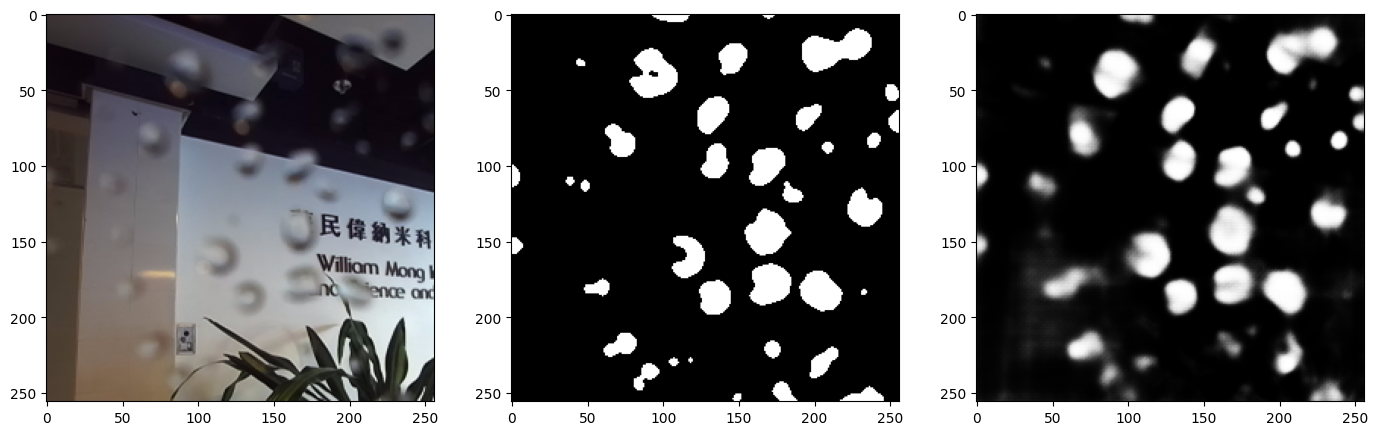

In [212]:
# Get prediction for random image and crop
from random import randint
idx = randint(0, len(val_dataset)-1)
print("Index:", idx)
x, y = val_dataset[idx]
plot_prediction(x, y, binary_map=False)

In [205]:
# Clear checkpoints by condition
clear_checkpoints(config["checkpoint_dir"], condition=lambda ch: ch["train_loss"] >= 0.27, save_last=1)

Removed checkpoints/UNetAdamBCEt27v30e60.pt


In [206]:
!ls -la checkpoints

total 1819424
drwxrwsr-x 2 kondrashov students      4096 Aug  6 23:37 .
drwxrwsr-x 5 kondrashov students      4096 Aug  6 23:37 ..
-rw-rw-r-- 1 kondrashov students 372610605 Aug  6 23:35 UNetAdamBCEt25v31e69.pt
-rw-rw-r-- 1 kondrashov students 372610605 Aug  6 23:35 UNetAdamBCEt26v29e66.pt
-rw-rw-r-- 1 kondrashov students 372610605 Aug  6 23:33 UNetAdamBCEt26v30e62.pt
-rw-rw-r-- 1 kondrashov students 372610605 Aug  6 23:35 UNetAdamBCEt26v30e67.pt
-rw-rw-r-- 1 kondrashov students 372610605 Aug  6 23:35 UNetAdamBCEt27v30e68.pt
